In [ ]:
!jupyter nbconvert --to html display.ipynb

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from generateRIR import generate_stochasticRIR
import control
from scipy import signal

In [21]:
ar  = torch.Tensor([1,2,3,4,5,6,7,8,9])
ar[::3]

tensor([1., 4., 7.])

(array([2., 1., 0., 1., 2., 0., 4., 1., 0., 3.]),
 array([-0.0147 , -0.01435, -0.014  , -0.01365, -0.0133 , -0.01295,
        -0.0126 , -0.01225, -0.0119 , -0.01155, -0.0112 ]),
 <BarContainer object of 10 artists>)

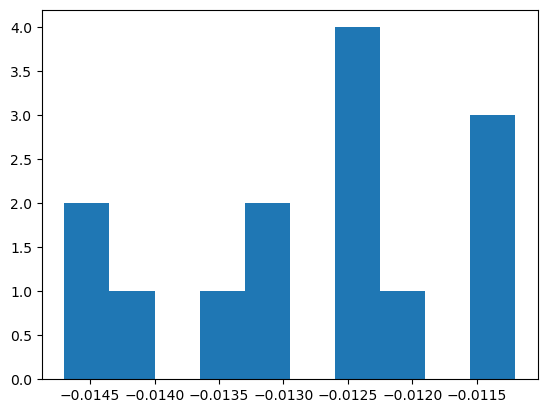

In [20]:
arr = torch.Tensor([-0.0112, -0.0115, -0.0171, -0.0147, -0.0118, -0.0149, -0.0126, -0.0105, -0.0187, -0.0121, -0.0109, -0.0197, -0.0123, -0.0105, -0.0206,-0.0114, -0.0120, -0.0206,-0.0143, -0.0113, -0.0166,-0.0114, -0.0095, -0.0185, -0.0125, -0.0106, -0.0184, -0.0134, -0.0110, -0.0203, -0.0125, -0.0094, -0.0164, -0.0133, -0.0100, -0.0191, -0.0145, -0.0127, -0.0167, -0.0131, -0.0102, -0.0182])
plt.hist(arr[::3])

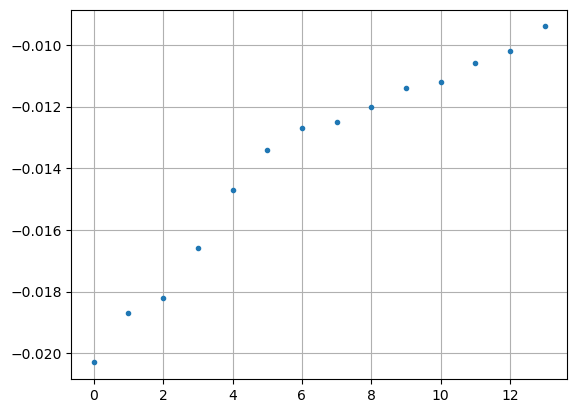

In [24]:
plt.plot(torch.sort(arr)[0][2::3], linestyle='', marker='.')
plt.grid()

In [9]:
def mag2db(xcv):
    return 20 * xcv.log10_()

size: 511 torch.Size([96000])


Text(0.5, 1.0, 'Squared RIR')

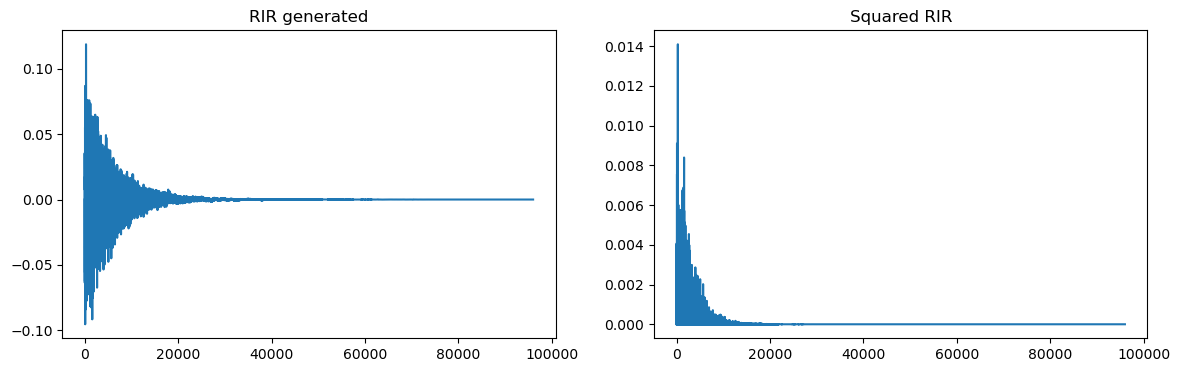

In [10]:
# generate RIR and get Envelope
yy = generate_stochasticRIR(L=torch.Tensor([3,4,5]))
# amplify 
gain = 100  # dB
#yy = yy * (10**(gain/20))
#
filter_ = torch.ones(1024)
filter_avg = filter_/torch.sum(filter_)
sqq = yy**2
padding_len = sqq.size(0)
print("size:", (filter_avg.size(0)-1)//2, sqq.size())
smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1)
in_db = mag2db(smoothed)
#
# filter_ = np.ones(1024)
# filter_avg = filter_/np.sum(filter_)
# sqq = yy**2
# smoothed = signal.convolve(sqq, filter_avg, mode='same')
# in_db = control.mag2db(smoothed)
plt.figure(1, figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(yy)
plt.title("RIR generated")
plt.subplot(1,2,2)
plt.plot(sqq)
plt.title("Squared RIR")

In [52]:
smoothed.requires_grad_()

tensor([ 6.7007,  6.7007,  6.7007,  ..., -4.3634, -4.3650, -4.3655],
       requires_grad=True)

In [11]:
smoothed.size()

torch.Size([96000])

In [7]:
smoothed.shape

(96000,)

In [12]:
in_db.requires_grad_()

tensor([ -67.0966,  -67.0959,  -67.0953,  ..., -237.3686, -237.4199,
        -237.4648], requires_grad=True)

In [8]:
in_db.shape

(96000,)

/tmp/ipykernel_61777/2823865782.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


Text(0.5, 1.0, 'Zoomed IN (Log axis)')

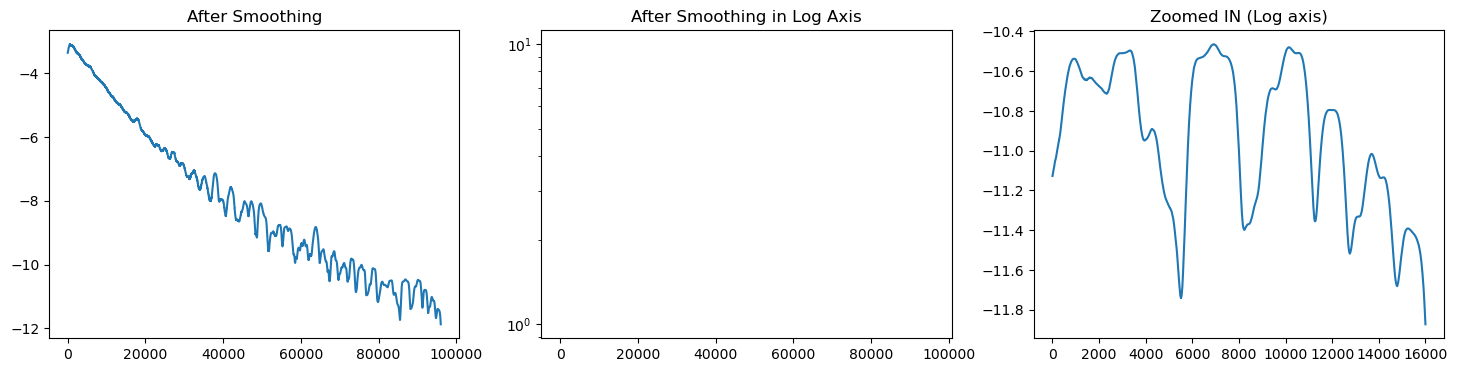

In [13]:
# Displaying the Smoothed RIR
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(smoothed.detach())
plt.title("After Smoothing")
plt.subplot(1,3,2)
plt.plot(smoothed.detach())
plt.yscale('log')
plt.title("After Smoothing in Log Axis")
plt.subplot(1,3,3)
plt.plot(smoothed.detach()[80000:])
#plt.yscale('log')
plt.title("Zoomed IN (Log axis)")

Text(0.5, 1.0, 'Zoomed IN(dB)')

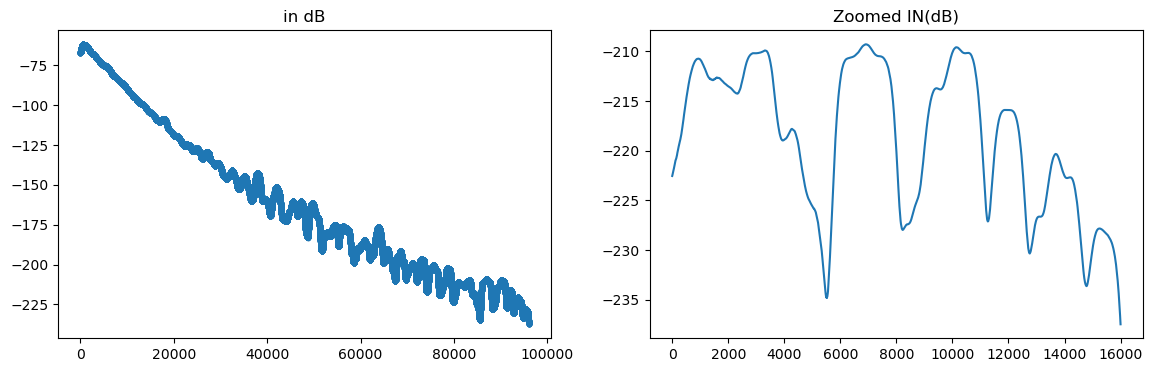

In [14]:
# This is after converting to DB
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(in_db.detach(), linestyle='', marker='.')
#plt.sca
#plt.yscale('log')
plt.title("in dB")
plt.subplot(1,2,2)
plt.plot(in_db.detach()[80000:])
#plt.yscale('log')
plt.title("Zoomed IN(dB)")

### Problem
Nan values are present after converting to dB.<br>
Also before Smoothing !!

So, I try to replace the Nan values after converting to dB with the previous valid values

In [5]:
db2 = in_db.copy()
mask = np.isnan(db2)
for i in range(1, len(db2)):
    if mask[i]:
        db2[i] = db2[i - 1]

In [ ]:
# After Replacing values

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(db2)
#plt.yscale('log')
plt.title("in dB")
plt.subplot(1,2,2)
plt.plot(db2[80000:])
#plt.yscale('log')
plt.title("Zoomed IN(dB)")

### Another solution
We can replace negative numbers from the smoothed RIR with epsillon

In [ ]:
smoothed2 = smoothed.copy()

In [ ]:
# Replace negative numbers with epsillon
smoothed2[smoothed2<0] = 2.2e-16

In [ ]:
# Displaying the Smoothed RIR
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(smoothed2)
plt.title("After Smoothing")
plt.subplot(1,3,2)
plt.plot(smoothed2)
plt.yscale('log')
plt.title("After Smoothing in Log Axis")
plt.subplot(1,3,3)
plt.plot(smoothed2[80000:])
#plt.yscale('log')
plt.title("Zoomed IN (Log axis)")

In [ ]:
# Convert to db
s_dB = control.mag2db(smoothed2)
#Plot
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(s_dB)
#plt.yscale('log')
plt.title("in dB")
plt.subplot(1,2,2)
plt.plot(s_dB[80000:])
#plt.yscale('log')
plt.title("Zoomed IN(dB)")

### Now Test

We generate Two RIR using same length L1, L2, L3. <br>
We check to see the loss values for the envelopes using our loss function<br>
#### Also using Clipping!

In [7]:
def mag2db(arr):
    return 20 * arr.log10_()
def env_maker0(arr, filter_=torch.ones(1024), gain=None, clip_=None):
    if gain is not None:
        arr = arr * (10**(gain/20))
    filter_avg = filter_/torch.sum(filter_)
    sqq = arr**2
    smoothed = torch.nn.functional.conv1d(sqq.reshape(1,-1), filter_avg.reshape(1,1,-1), bias=None, stride=1, padding='same' ).reshape(-1,)
    in_db = mag2db(smoothed)
    if clip_ is not None:
        #
        in_db = torch.clip(in_db, min=clip_)
    return in_db
    

In [16]:
# using the first approach
def env_maker(arr, filter_ = np.ones(1024), gain=50):
    filter_avg = filter_/np.sum(filter_)
    sqq = arr**2
    # amplify
    #sqq = sqq * (10**(gain/20))
    # smooth
    xs = signal.convolve(sqq, filter_avg, mode='same')
    in_db =control.mag2db(xs)
    # clip till -150
    in_db = np.clip(in_db, a_min=-150, a_max=1000)
    # replace values that are not defined with neighbours
    mask_db = np.isnan(in_db)
    for i in range(1, len(in_db)):
        if mask_db[i]:
            in_db[i] = in_db[i - 1]
    return torch.Tensor(in_db)

# using the second approach
def env_maker1(arr, filter_ = np.ones(1024), gain=50):
    eps=2.2204e-16
    filter_avg = filter_/np.sum(filter_)
    sqq = arr**2
    # amplify
    sqq = sqq * (10**(gain/20))
    # smooth
    xs = signal.convolve(sqq, filter_avg, mode='same')
    # remove values less than 0 with epsillon in the smotthed RIR
    xs[xs<0] = eps
    in_db = control.mag2db(xs)
    # Clip till -150dB
    return torch.clip(torch.Tensor(in_db), min=-150)
    #return torch.Tensor(in_db)

In [ ]:
# using the second approach and amplifying
def env_maker2(arr, filter_ = np.ones(4096), gain=50):
    eps=2.2204e-16
    filter_avg = filter_/np.sum(filter_)
    
    sqq = arr**2
    xs = signal.convolve(sqq, filter_avg, mode='same')
    # remove values less than 0 with epsillon in the smotthed RIR
    xs[xs<0] = eps
    plt.figure(1)
    plt.plot(xs)
    in_db = control.mag2db(xs)
    plt.figure(2)
    plt.plot(in_db)
    # amplify 
    #in_dB = in_db + gain
    # Clip till -150dB
    return torch.clip(torch.Tensor(in_db), min=-150)
    #return torch.Tensor(in_dB)

In [2]:
# Generate and Define values
xx = generate_stochasticRIR(L=torch.Tensor([3,4,5]))#.detach()
yy = generate_stochasticRIR(L=torch.Tensor([3,4,5]))#.detach()
J = np.array([1,2,4,8,16,32]) * 128
crit = torch.nn.MSELoss()

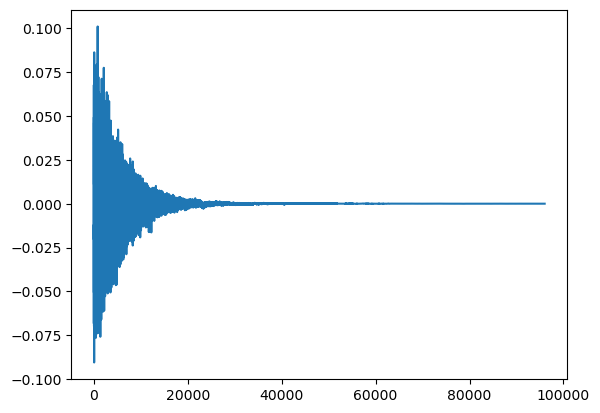

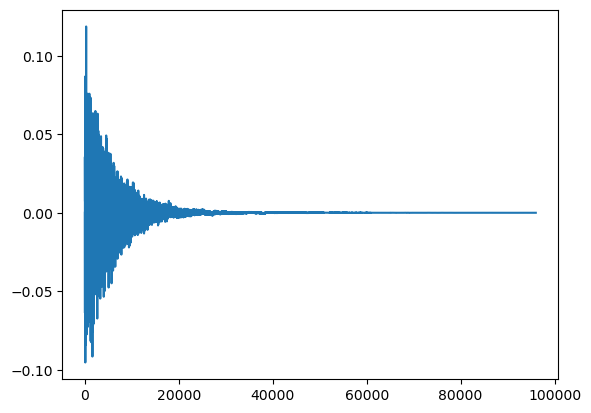

In [3]:
plt.figure(1)
plt.plot(xx)
plt.figure(2)
plt.plot(yy)

for filterSize:128, lossValue: 7.474542140960693
for filterSize:256, lossValue: 6.845749378204346
for filterSize:512, lossValue: 5.983170032501221
for filterSize:1024, lossValue: 4.773606777191162
for filterSize:2048, lossValue: 3.3852782249450684
for filterSize:4096, lossValue: 2.6314001083374023


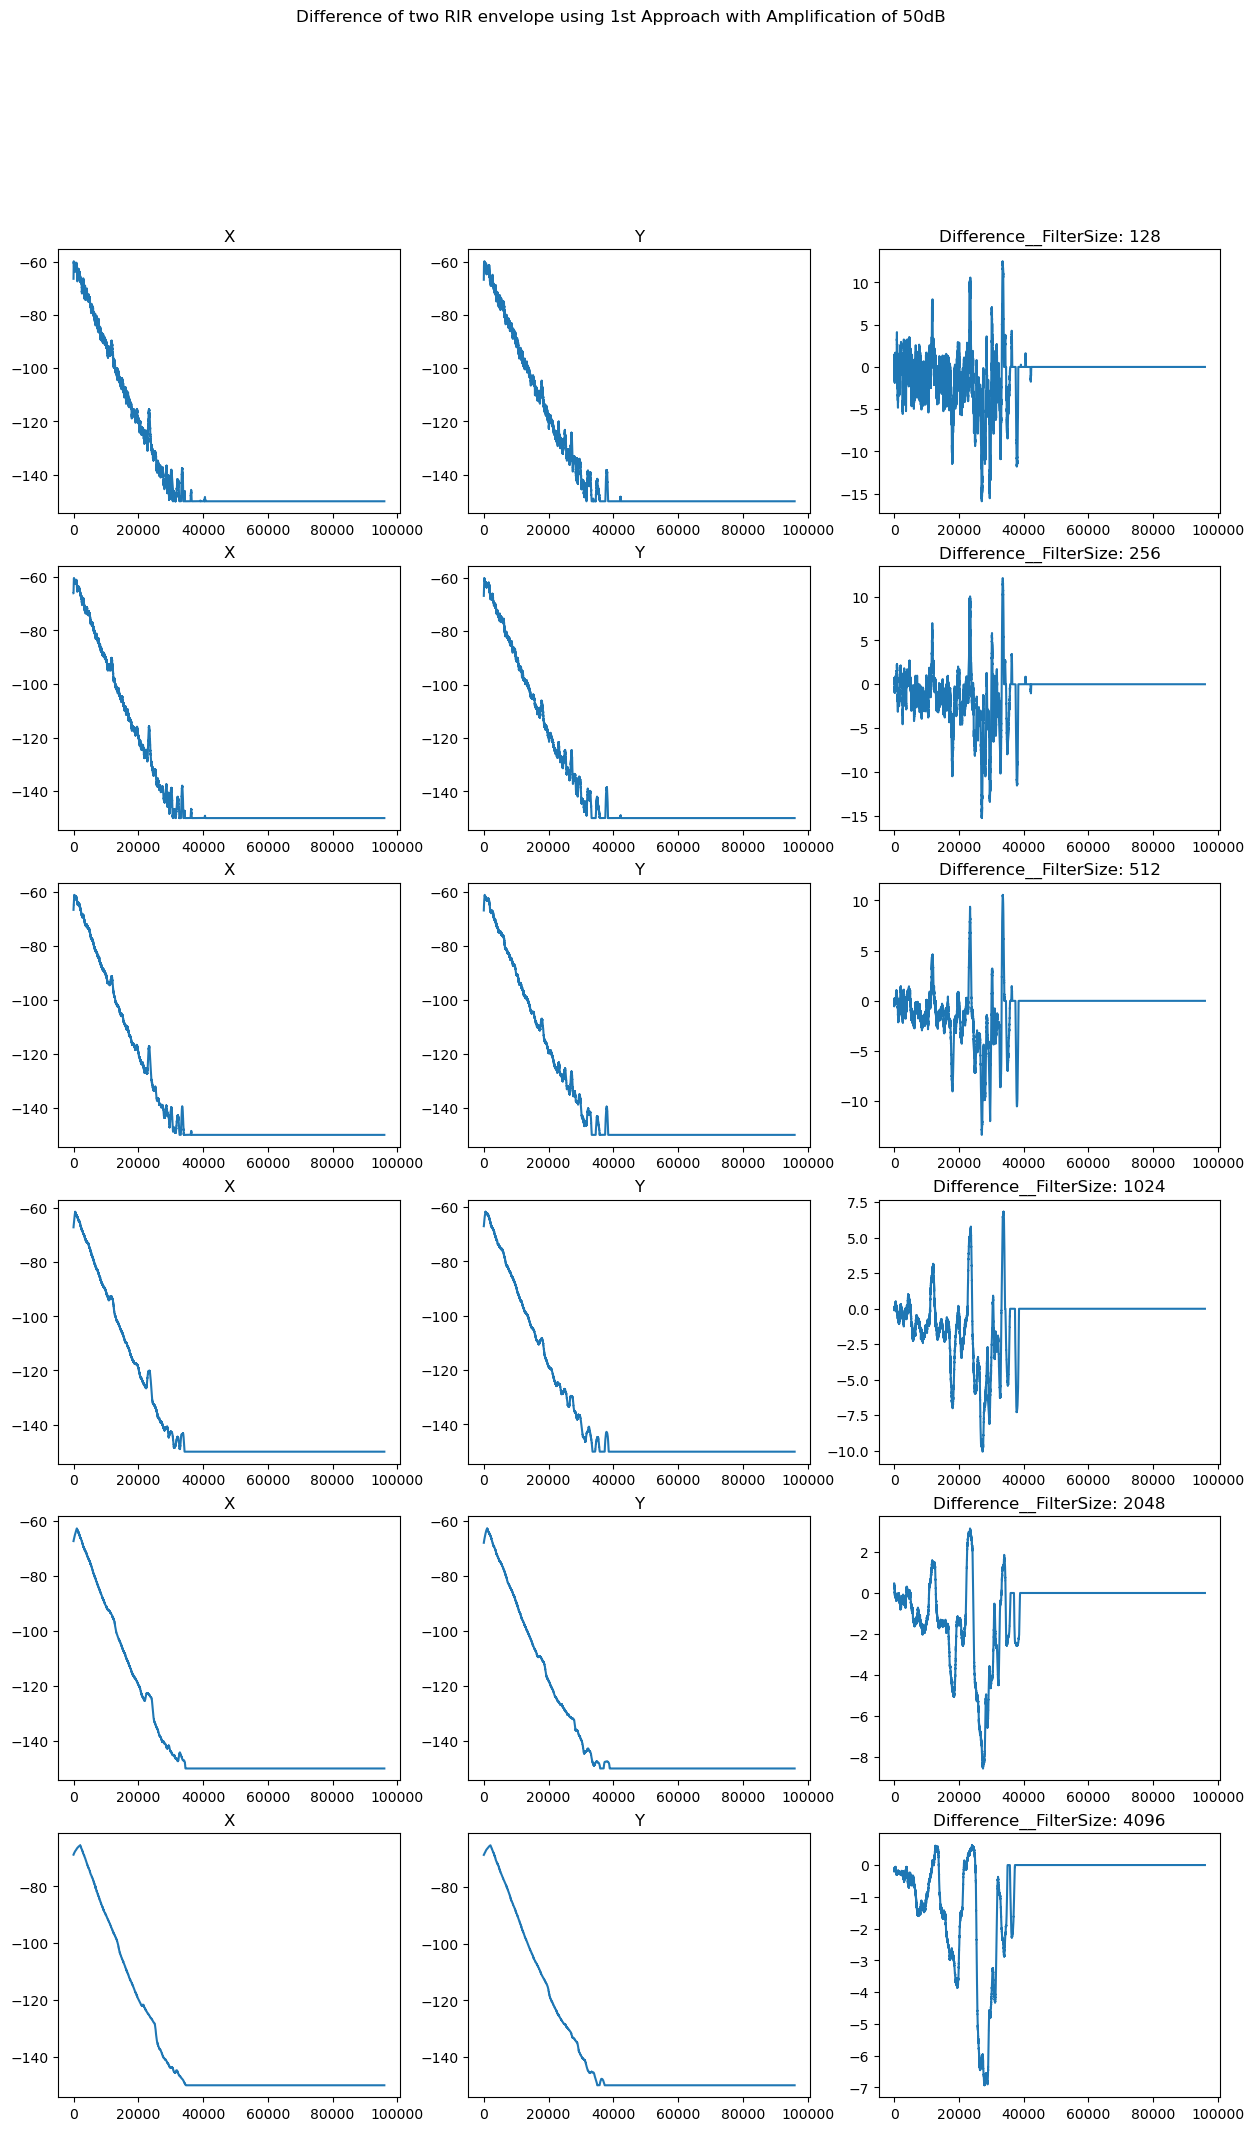

In [9]:
# First Approach
envsX = torch.zeros((xx.size(0)))
envsY = torch.zeros((yy.size(0)))
gain_ = None
clip_min = -150  #dB
plt.figure(figsize=(15,24))
plt.suptitle("Difference of two RIR envelope using 1st Approach with Amplification of 50dB")
for idx, i in enumerate(J):
    x_env = env_maker0(xx, filter_=torch.ones(i), gain=gain_, clip_=clip_min)
    y_env = env_maker0(yy, filter_=torch.ones(i), gain=gain_, clip_=clip_min)
    #print(x_env.size(), y_env.size())
    # envsX = torch.vstack((envsX, x_env))
    # envsY = torch.vstack((envsY, y_env))
    plt.subplot(6,3,3*idx+1)
    plt.title("X")
    plt.plot(x_env)
    plt.subplot(6,3,3*idx+2)
    plt.title("Y")
    plt.plot(y_env)
    plt.subplot(6,3,3*idx+3)
    plt.title(f'Difference__FilterSize: {i}')
    plt.plot(x_env-y_env)
    l = crit(x_env, y_env)
    print(f'for filterSize:{i}, lossValue: {l}')
# envsX = envsX[1:, :]
# envsY = envsY[1:, :]

In [ ]:
# Second Approach
envsX2 = torch.zeros((xx.size(0)))
envsY2 = torch.zeros((yy.size(0)))
plt.figure(figsize=(15,8))
for idx, i in enumerate(J):
    x_env = env_maker1(xx, filter_=np.ones(i))
    y_env = env_maker1(yy, filter_=np.ones(i))
    envsX = torch.vstack((envsX2, x_env))
    envsY = torch.vstack((envsY2, y_env))
    plt.subplot(2,3,idx+1)
    plt.plot(x_env-y_env)
    l = crit(x_env, y_env)
    print(f'for filterSize:{i}, lossValue: {np.round(l.item(), 4)}')
envsX2 = envsX[1:, :]
envsY2 = envsY[1:, :]

Seems both approach give Similar Results!

In [ ]:
# Printing values for a number of RIR pairs for each Filter value
for j in J:
    for i in range(5):
        xx = generate_stochasticRIR(L=torch.Tensor([3,4,5])).detach()
        yy = generate_stochasticRIR(L=torch.Tensor([3,4,5])).detach()
        x_env = env_maker2(xx, filter_=np.ones(j))
        y_env = env_maker2(yy, filter_=np.ones(j))
        l = crit(x_env, y_env)
        print(f'for RIR {i} filterSize:{j}, lossValue: {np.round(l.item(), 4)}')
        


As seen the loss value is quite high !
Due to the Randomness it can be vary for the same filterSize